In [435]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [436]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [437]:
NUM_CLASSES = 25

# Dataset reading

In [438]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2*2) + 1)))

In [439]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [440]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [441]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2*2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [442]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_44 (Dropout)        (None, 84)                0         
                                                                 
 dense_66 (Dense)            (None, 30)                2550      
                                                                 
 dropout_45 (Dropout)        (None, 30)                0         
                                                                 
 dense_67 (Dense)            (None, 10)                310       
                                                                 
 dense_68 (Dense)            (None, 25)                275       
                                                                 
Total params: 3,135
Trainable params: 3,135
Non-trainable params: 0
_________________________________________________________________


In [443]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [444]:
# Model compilation
model.compile(
    optimizer='adam',
    #loss='mean_squared_error',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [445]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=256,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
44/60 [=====================>........] - ETA: 0s - loss: 3.1440 - accuracy: 0.0854
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
60/60 [==============================] - 1s 6ms/step - loss: 3.0949 - accuracy: 0.1093 - val_loss: 2.8286 - val_accuracy: 0.1912
Epoch 2/1000
50/60 [========================>.....] - ETA: 0s - loss: 2.6917 - accuracy: 0.2244
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
60/60 [==============================] - 0s 3ms/step - loss: 2.6547 - accuracy: 0.2338 - val_loss: 2.2619 - val_accuracy: 0.3510
Epoch 3/1000
51/60 [========================>.....] - ETA: 0s - loss: 2.2231 - accuracy: 0.3326
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
60/60 [==============================] - 0s 3ms/step - loss: 2.1994 - accuracy: 0.3343 - val_loss: 1.7893 - val_accuracy: 0.5243
Epoch 4/1000
50/60 [========================>.....] - ETA: 0s - loss: 1.8852 - accuracy: 0.3852
E

In [446]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

40/40 [==============================] - 0s 1ms/step - loss: 0.0176 - accuracy: 1.0000


In [447]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [448]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 64ms/step
[6.6150209e-23 4.1850259e-11 9.9526191e-01 2.1866188e-07 6.0114596e-21
 2.0176587e-09 0.0000000e+00 2.4708392e-08 0.0000000e+00 1.0836628e-06
 1.1035340e-31 2.3126678e-15 1.7755561e-34 1.1395600e-05 4.7237687e-03
 5.2681618e-31 2.3155637e-22 3.3155925e-07 4.9616139e-36 4.2505077e-34
 4.7924935e-30 4.7744528e-09 6.0573953e-32 1.9774199e-38 1.2983495e-06]
2


# Confusion matrix

158/158 [==============================] - 0s 1ms/step


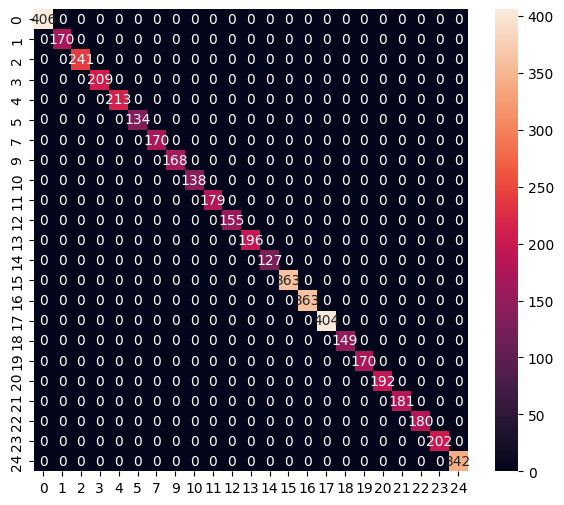

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       406
           1       1.00      1.00      1.00       170
           2       1.00      1.00      1.00       241
           3       1.00      1.00      1.00       209
           4       1.00      1.00      1.00       213
           5       1.00      1.00      1.00       134
           7       1.00      1.00      1.00       170
           9       1.00      1.00      1.00       168
          10       1.00      1.00      1.00       138
          11       1.00      1.00      1.00       179
          12       1.00      1.00      1.00       155
          13       1.00      1.00      1.00       196
          14       1.00      1.00      1.00       127
          15       1.00      1.00      1.00       363
          16       1.00      1.00      1.00       363
          17       1.00      1.00      1.00       404
          18       1.00      1.00      1.00       149
     

In [449]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [450]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [451]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\jonas\AppData\Local\Temp\tmpi7cd3aab\assets


INFO:tensorflow:Assets written to: C:\Users\jonas\AppData\Local\Temp\tmpi7cd3aab\assets


7248

# Inference test

In [452]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [453]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [454]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [455]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [456]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[6.5949819e-23 4.7555095e-11 9.9427778e-01 2.2479000e-07 6.5814924e-21
 2.5090126e-09 0.0000000e+00 2.6081553e-08 0.0000000e+00 1.3767944e-06
 1.0130255e-31 2.4620067e-15 1.6025928e-34 1.1864867e-05 5.7067773e-03
 5.7620387e-31 2.3805222e-22 3.8987224e-07 4.6914845e-36 4.4070105e-34
 4.7040794e-30 4.9062283e-09 7.4908689e-32 2.3375358e-38 1.6201265e-06]
2
